8-10 runs
10 vectors in the attack
sample 5 from the test set
sample 5 from the training set
IT IS IMPORTANT THAT THESE ARE RANDOM

DO MULTIPLE RUNS

Store the data in a dataframe
For every run store, th, k, prec, recall, acc
Can then use directly with Seaborn

PLOT RESULTS WITH A 95% CONFIDENCE InteRVAL
^ Can do this with built in function in Python

In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.special import rel_entr

In [3]:
def isMatch(v1,v2,k,th):
    '''
    Are a match is there is a common k-subsequence that is matched with L1 dist <= th
    '''
    
    # If len(v1)=31 and k=31, then this is range(0,1) ---- k <= len(v1)
    for i in range(0,len(v1)-k+1):
        #print(i)
        a = np.array([v1[i:i+k]])
        for j in range(0,len(v2)-k+1):
            #b = np.array([v2[i:i+k]])  # Original code, different type of match, 
            b = np.array([v2[j:j+k]])  # Not run yet, this uses any sliding window
            
            # Should I zero pad b, truncate a, or just return false?
            while (a.shape[1] > b.shape[1]):
                b = np.append(b, 0)
                b = np.reshape(b, (1, len(b)))
            
            if (np.linalg.norm((a - b), ord=1) <= th):
                return True
            
    return False

In [4]:
################## DATA FRAME ##################
datafile = 'Data/Fitbit_Kaggle/dailyActivity_merged.csv'
all_fields = ['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 
          'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 
          'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

#pd.set_option('display.max_rows', 100)
df = pd.read_csv(datafile, skipinitialspace=True, usecols=all_fields)
fields = 'FairlyActiveMinutes'
selected_data = df[['Id',fields]]
n_rows, n_cols = df.shape

selected_data.head()

,Id,FairlyActiveMinutes
0,1503960366,13
1,1503960366,19
2,1503960366,11
3,1503960366,34
4,1503960366,10


In [5]:
def isMatch(v1,v2,k,th):
    '''
    Are a match is there is a common k-subsequence that is matched with L1 dist <= th
    '''
    
    # If len(v1)=31 and k=31, then this is range(0,1) ---- k <= len(v1)
    for i in range(0,len(v1)-k+1):
        a = np.array([v1[i:i+k]])
        for j in range(0,len(v2)-k+1):
            #b = np.array([v2[j:j+k]])
            b = np.array([v2[i:i+k]])
            
            # Should I zero pad b, truncate a, or just return false?
            while (a.shape[1] > b.shape[1]):
                b = np.append(b, 0)
                b = np.reshape(b, (1, len(b)))
            
            if (np.linalg.norm((a - b), ord=1) <= th):
                return True
            
    return False

In [7]:
def run_n_attacks(df, num_attacks, ths=[0,2,5], k_vec=[1,5,10,20,30], sample_size=2):
    fields = 'FairlyActiveMinutes'
    my_cols = ['Trial', 'Test_IDs', 'Threshold', 'K', 'Precision', 'Recall', 'Accuracy']
    res_df = pd.DataFrame(columns=my_cols)

    all_IDs = df.Id.unique()
    num_users = len(all_IDs)

    user_dict = dict()
    for idx, user in enumerate(all_IDs):
        temp_df = df.loc[df['Id'] == user]
        user_dict[user] = temp_df[fields].values
    ##########################################################

    # LOOPING THROUGH THE NUMBER OF ATTACKS DESIRED
    for trial_num in range(num_attacks):
        #test_IDs = all_IDs[[0, 1]]
        test_IDs = random.sample(list(all_IDs), 2)
        n_attack_training = len(test_IDs)

        training_IDs = [ID for ID in all_IDs if ID not in test_IDs]
        shuffled_training_IDs = list(random.sample(training_IDs, len(training_IDs)))
        attack_IDs = list(test_IDs) + shuffled_training_IDs[0:n_attack_training]
        #attack_IDs = list(test_IDs) + list(training_IDs[0:2])
        print("SANITY CHECK:")
        for i in attack_IDs:
            print(f"{i} in training_IDs: {i in training_IDs}")

        print("TEST IDs:")
        print()
        print(test_IDs)
        for i in range(len(test_IDs)):
            print("TEST VALS " + str(i+1))
            print(user_dict[test_IDs[i]])
            print()
        ##########################################################
        # Max number of elements for any field
        max_elements = 31

        # Storage Initialization
        data_storage = np.zeros((len(attack_IDs), len(training_IDs), len(ths), max_elements, len(k_vec)))

        n_attack_training = len(attack_IDs) - len(test_IDs)
        true_positives = np.zeros((len(ths), len(k_vec)))
        false_negatives = np.zeros((len(ths), len(k_vec)))
        ##########################################################
        matching_matrix = np.zeros((len(attack_IDs), len(training_IDs), len(ths), len(k_vec))) + 9
        for i, attack_ID in enumerate(attack_IDs):
            v1 = user_dict[attack_ID]
            for k_idx, k in enumerate(k_vec):
                # POSSIBLE ISSUE
                # We shuffled the training IDs... so matching_matrix is thrown off... need to compensate for this somehow...
                for j, training_ID in enumerate(training_IDs): #shuffled_training_IDs[0:n_attack_training] #(training_IDs[:2]):
                    v2 = user_dict[training_ID]

                    for l, th in enumerate(ths):
                        if (isMatch(v1,v2,k,th)):
                            matching_matrix[i,j,l,k_idx] = 1
                        else:
                            matching_matrix[i,j,l,k_idx] = 0
        ##########################################################
        for attack_idx, attack_ID in enumerate(attack_IDs):
            if attack_ID in training_IDs:
                label_idx = training_IDs.index(attack_ID)
                for j in range(len(ths)):
                    for k_idx in range(len(k_vec)):
                        if matching_matrix[attack_idx, label_idx, j, k_idx] == 1:
                            true_positives[j, k_idx] += 1
                        else:
                            false_negatives[j, k_idx] += 1                    
        ##########################################################                 
        for j in range(len(ths)):
            for k_idx in range(len(k_vec)):
                if true_positives[j, k_idx] == n_attack_training:
                    # Note that this is not necessarily mean all of them were true positives
                    print(f"Th={ths[j]}, k={k_vec[k_idx]}: Correct number of positives found ({int(true_positives[j, k_idx])})!")
                else:
                    print(f"Th={ths[j]}, k={k_vec[k_idx]}: Incorrect number of positives... found ({int(true_positives[j, k_idx])}) vs expected ({n_attack_training})")
        ##########################################################            
        for j in range(len(ths)):
            for k_idx in range(len(k_vec)):
                all_positives = np.count_nonzero(matching_matrix[:,:,j,k_idx] == 1) 
                false_positives = all_positives - true_positives[j, k_idx]
                true_negatives = np.product(matching_matrix.shape) - all_positives - false_negatives[j, k_idx]

                precision = true_positives[j, k_idx] / (true_positives[j, k_idx] + false_positives)
                recall = true_positives[j, k_idx] / (true_positives[j, k_idx] + false_negatives[j, k_idx])
                accuracy = (true_positives[j, k_idx] + true_negatives) / np.product(matching_matrix.shape)

                new_row = [trial_num, test_IDs, ths[j], k_vec[k_idx], precision, recall, accuracy]
                new_df = pd.DataFrame([new_row], columns=my_cols)
                res_df = pd.concat([res_df, new_df])

        print("--------------------------------------------")
        print("END OF ATTACK NUMBER " + str(trial_num+1))
        print("--------------------------------------------")
        print()

    return res_df

In [8]:
res_df = run_n_attacks(df, 8, sample_size=2)

SANITY CHECK:
1927972279 in training_IDs: False
2026352035 in training_IDs: False
4558609924 in training_IDs: True
7086361926 in training_IDs: True
TEST IDs:

[1927972279, 2026352035]
TEST VALS 1
[0 0 9 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 1 8 0 0 0 0 0 0 0 0 0 0]

TEST VALS 2
[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Th=0, k=1: Correct number of positives found (2)!
Th=0, k=5: Correct number of positives found (2)!
Th=0, k=10: Correct number of positives found (2)!
Th=0, k=20: Correct number of positives found (2)!
Th=0, k=30: Correct number of positives found (2)!
Th=2, k=1: Correct number of positives found (2)!
Th=2, k=5: Correct number of positives found (2)!
Th=2, k=10: Correct number of positives found (2)!
Th=2, k=20: Correct number of positives found (2)!
Th=2, k=30: Correct number of positives found (2)!
Th=5, k=1: Correct number of positives found (2)!
Th=5, k=5: Correct number of positives found (2)!
Th=5, k=10: Correct number of positives found (2)!
Th=5,

Th=0, k=1: Correct number of positives found (2)!
Th=0, k=5: Correct number of positives found (2)!
Th=0, k=10: Correct number of positives found (2)!
Th=0, k=20: Correct number of positives found (2)!
Th=0, k=30: Incorrect number of positives... found (1) vs expected (2)
Th=2, k=1: Correct number of positives found (2)!
Th=2, k=5: Correct number of positives found (2)!
Th=2, k=10: Correct number of positives found (2)!
Th=2, k=20: Correct number of positives found (2)!
Th=2, k=30: Incorrect number of positives... found (1) vs expected (2)
Th=5, k=1: Correct number of positives found (2)!
Th=5, k=5: Correct number of positives found (2)!
Th=5, k=10: Correct number of positives found (2)!
Th=5, k=20: Correct number of positives found (2)!
Th=5, k=30: Incorrect number of positives... found (1) vs expected (2)
--------------------------------------------
END OF ATTACK NUMBER 8
--------------------------------------------



In [9]:
res_df.head(10000)

,Trial,Test_IDs,Threshold,K,Precision,Recall,Accuracy
0,0,"[1927972279, 2026352035]",0,1,0.017391,1.0,0.939247
0,0,"[1927972279, 2026352035]",0,5,0.066667,1.0,0.984946
0,0,"[1927972279, 2026352035]",0,10,0.105263,1.0,0.990860
0,0,"[1927972279, 2026352035]",0,20,1.000000,1.0,1.000000
0,0,"[1927972279, 2026352035]",0,30,1.000000,1.0,1.000000
0,0,"[1927972279, 2026352035]",2,1,0.016129,1.0,0.934409
0,0,"[1927972279, 2026352035]",2,5,0.064516,1.0,0.984409
0,0,"[1927972279, 2026352035]",2,10,0.100000,1.0,0.990323
0,0,"[1927972279, 2026352035]",2,20,1.000000,1.0,1.000000
0,0,"[1927972279, 2026352035]",2,30,1.000000,1.0,1.000000


In [25]:
my_metric_ys

[]

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


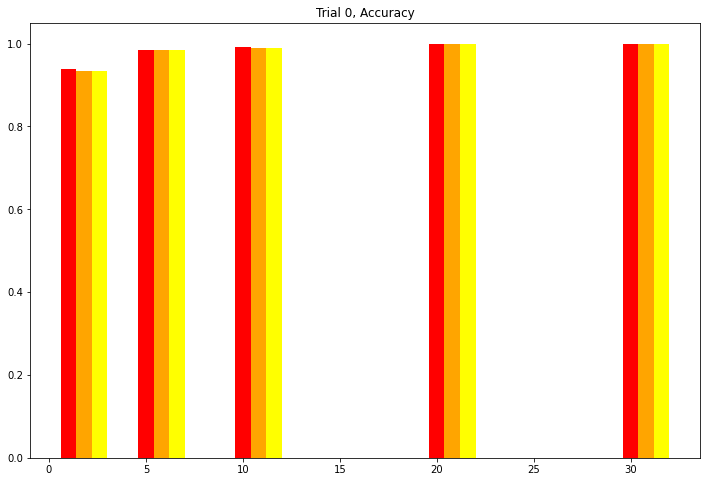

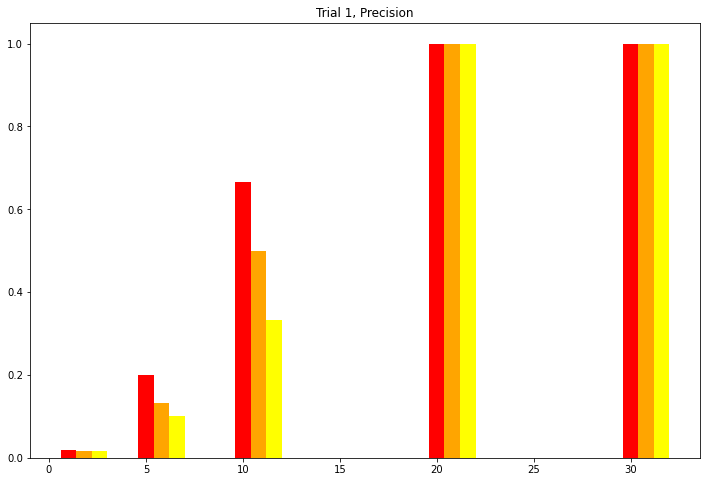

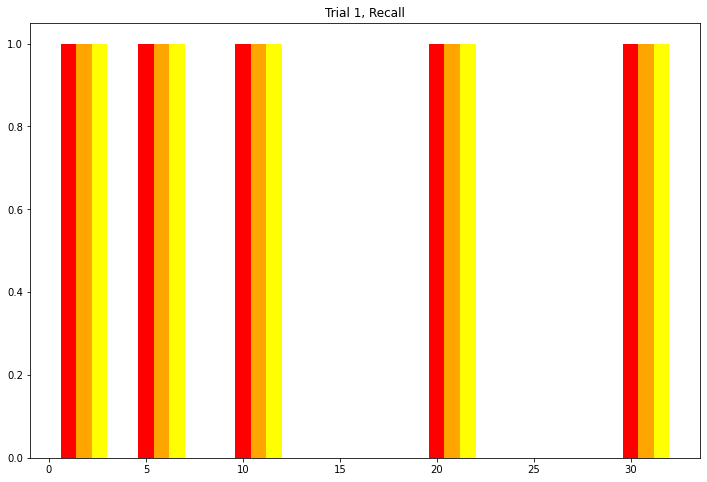

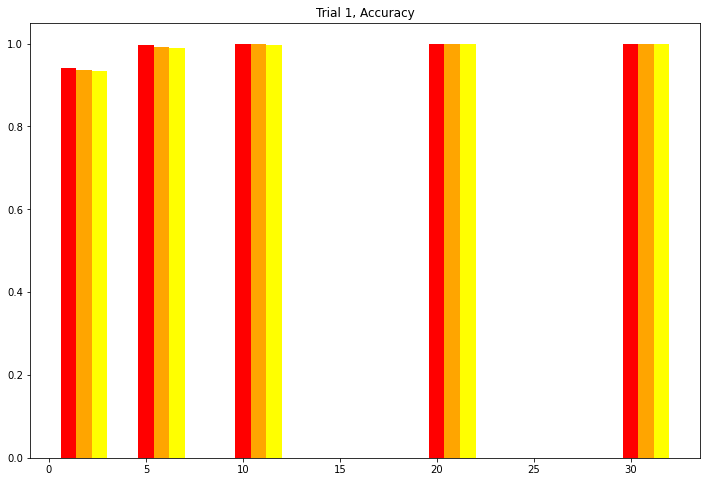

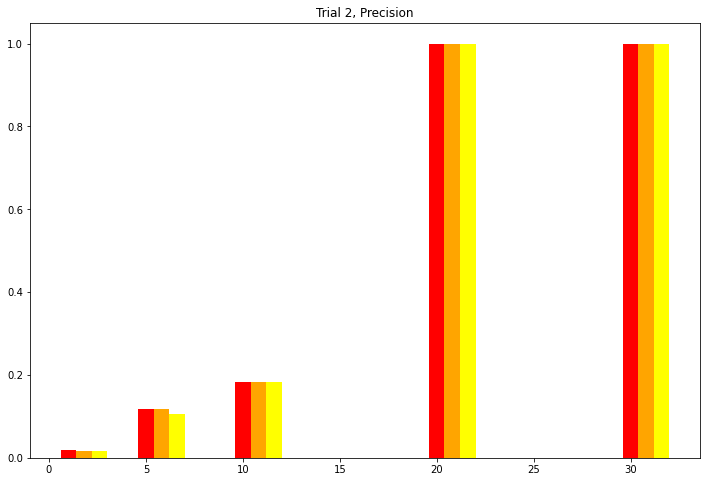

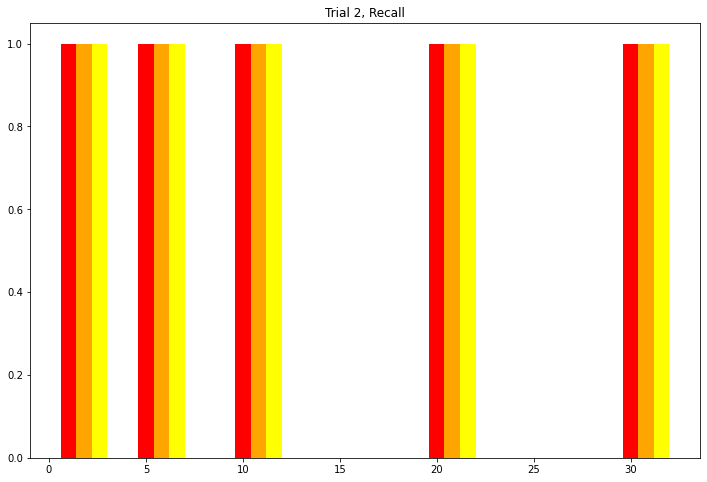

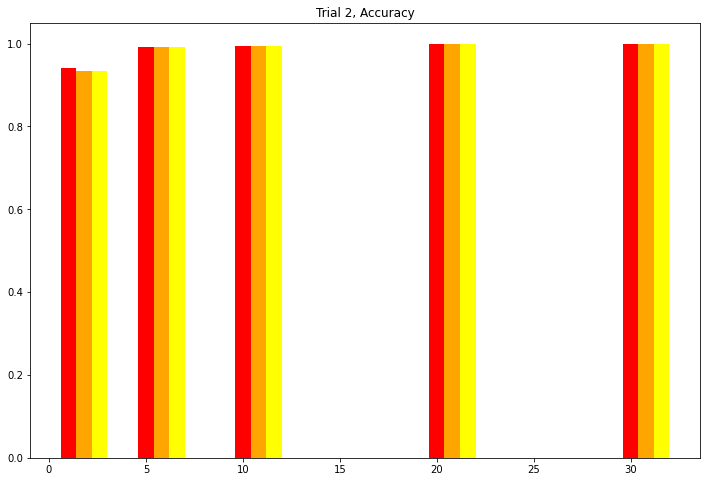

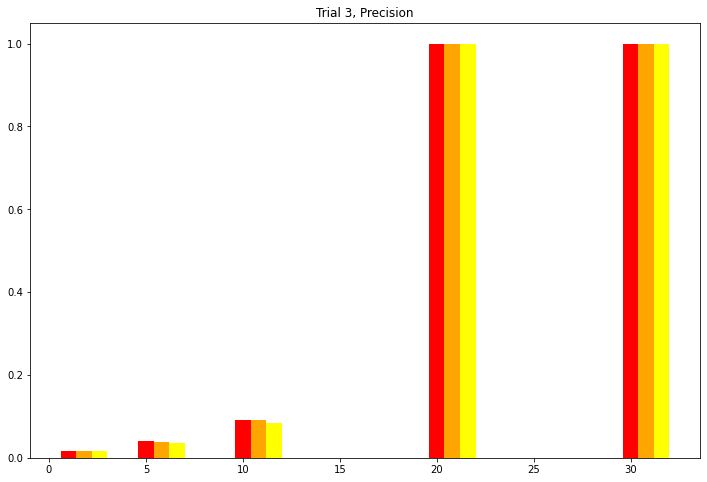

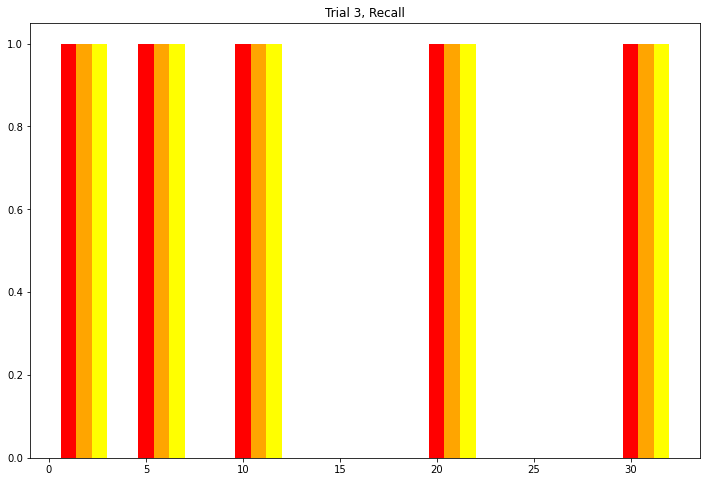

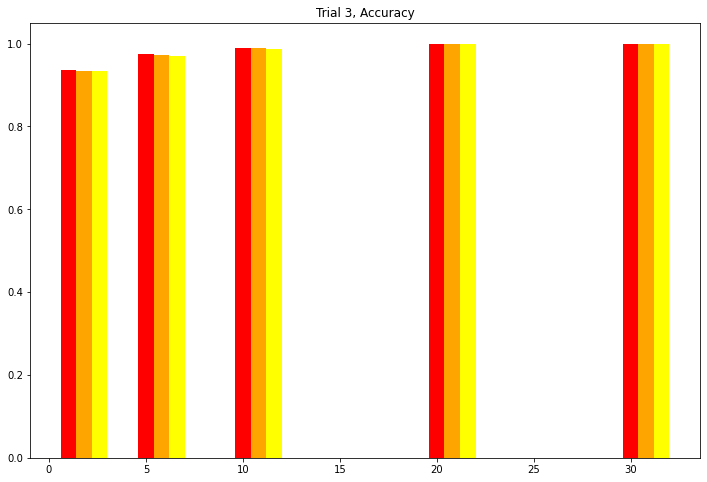

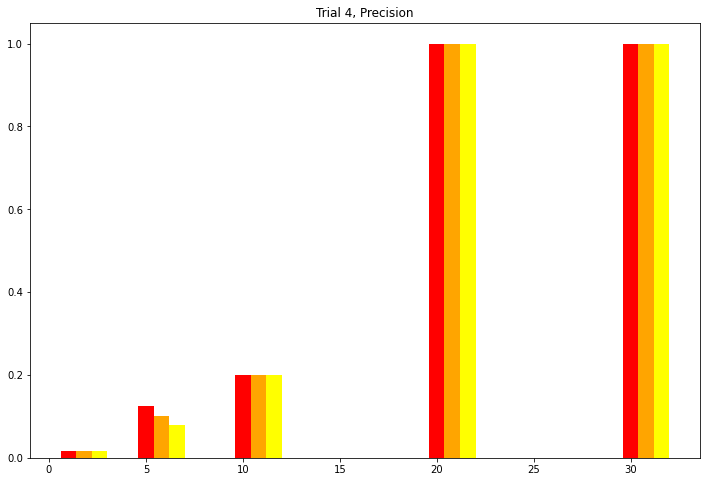

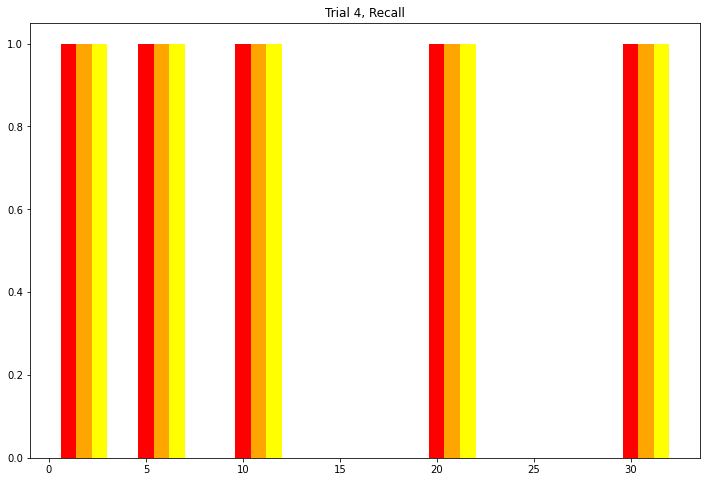

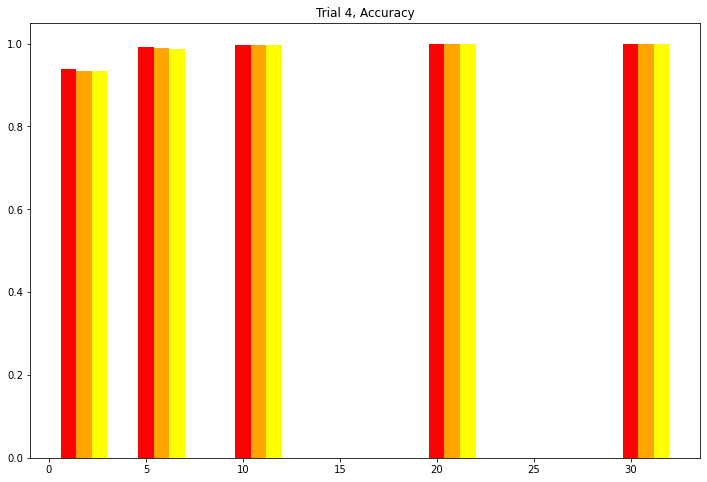

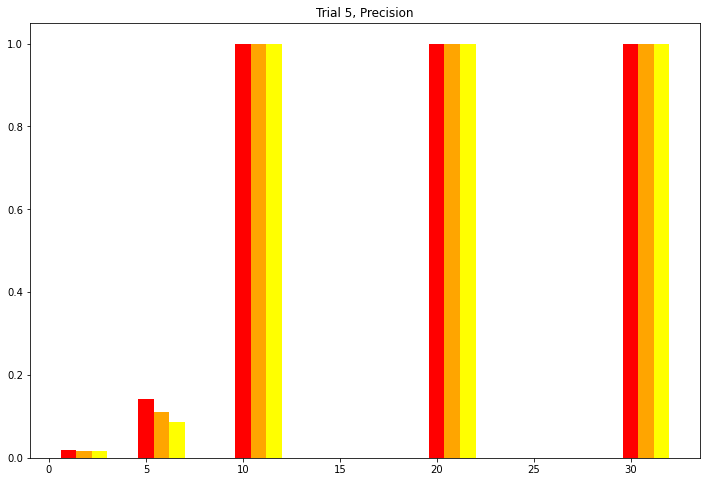

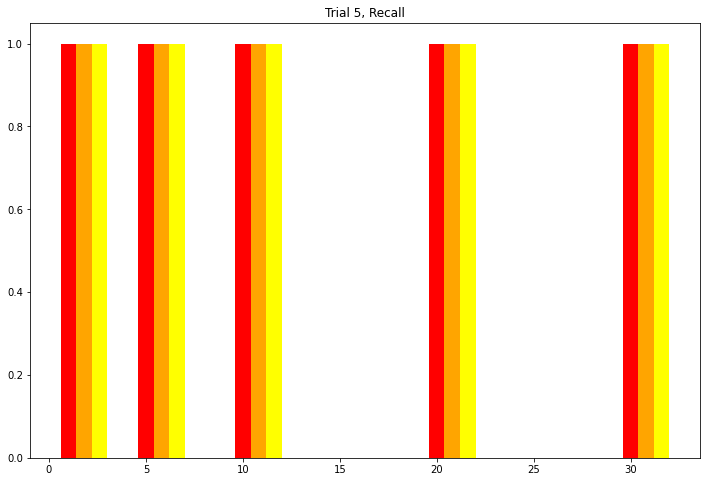

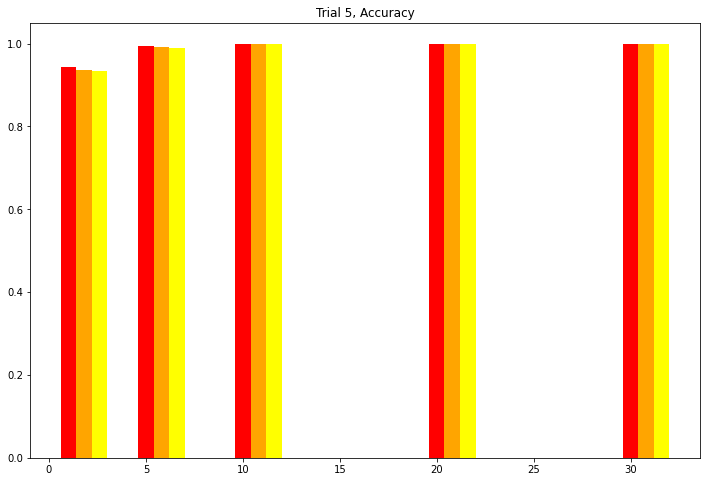

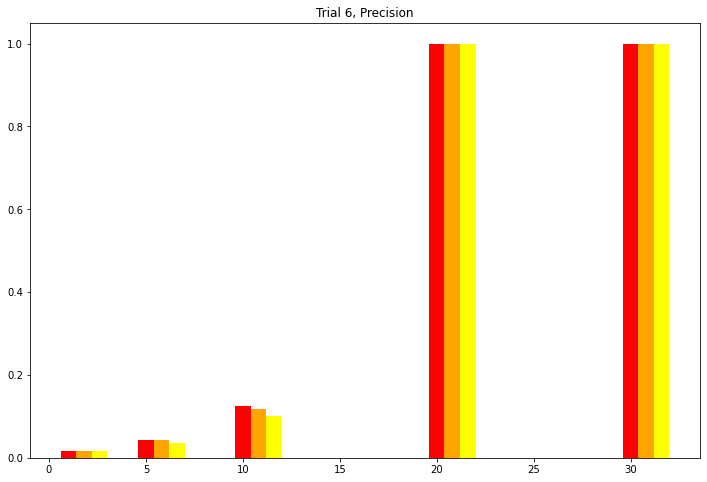

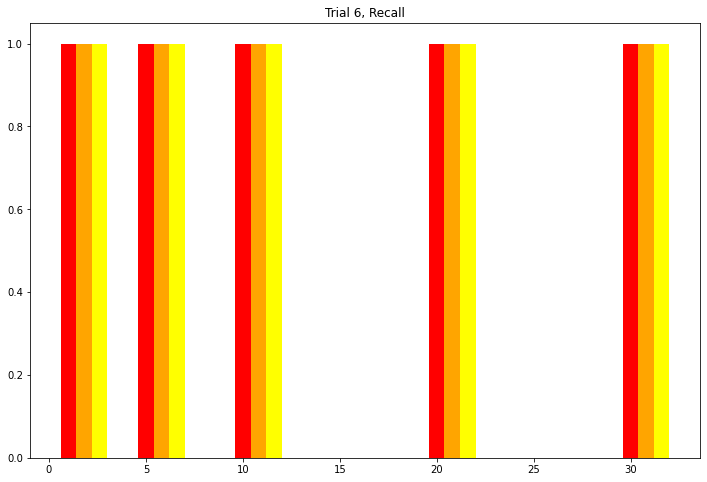

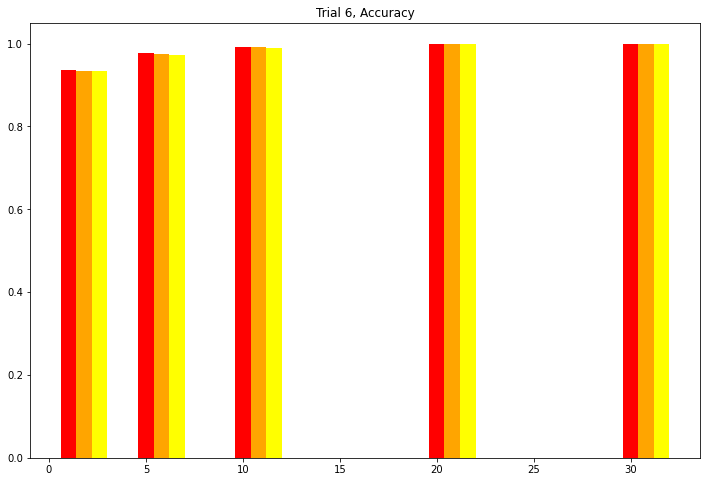

<Figure size 432x288 with 0 Axes>

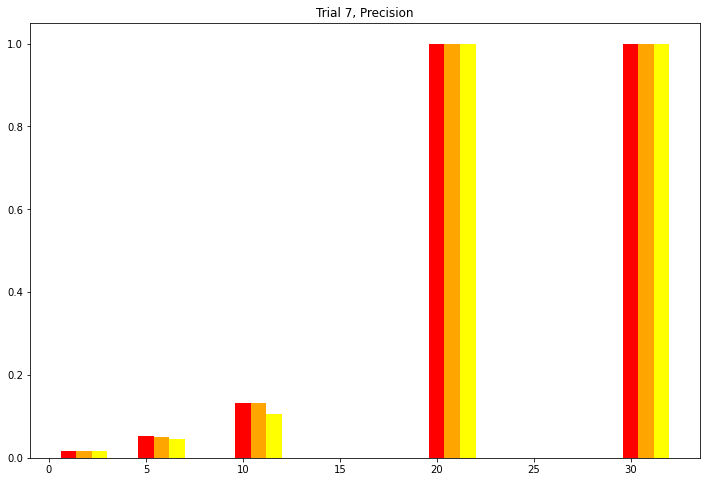

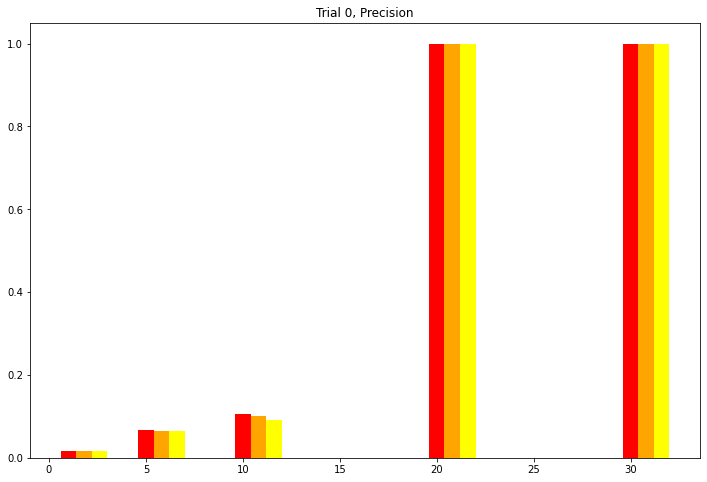

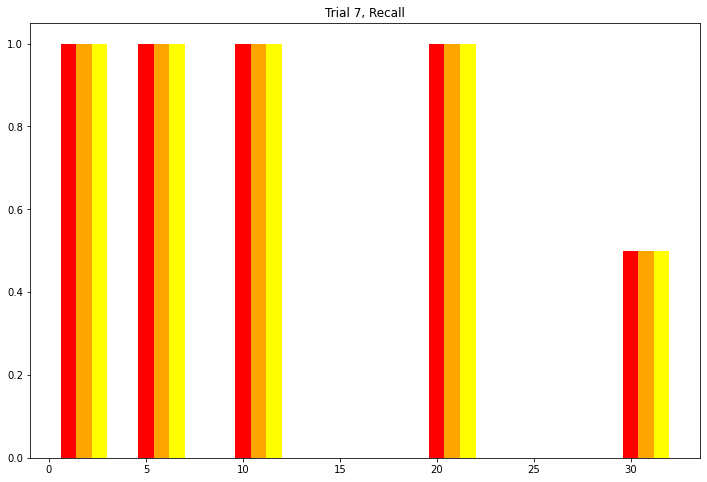

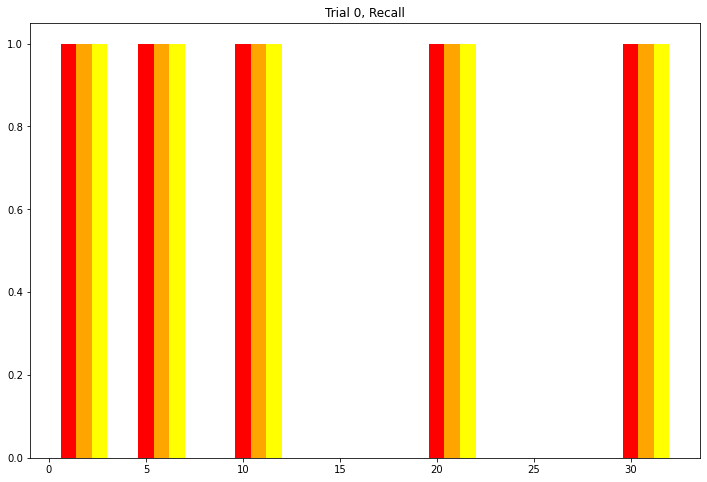

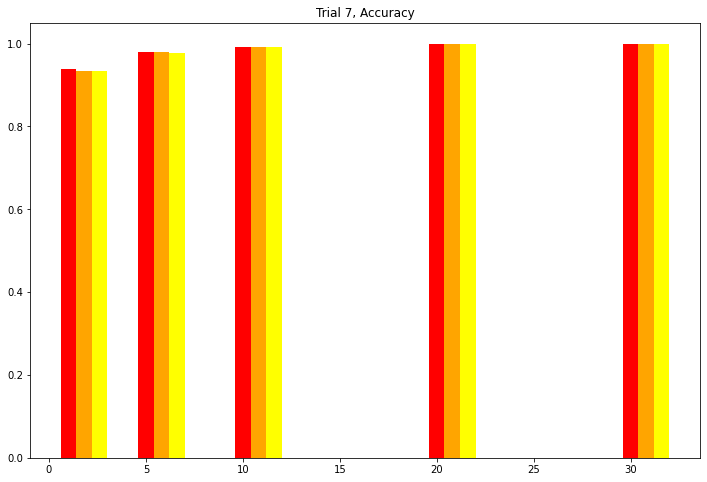

In [29]:
res_df.fillna(0)
width = 0.8
num_trials = 8
my_xs = [1,5,10,20,30]
my_metrics = ['Precision', 'Recall', 'Accuracy']
my_color_scheme =  ['red', 'orange','yellow', 'gold']

for i in range(num_trials):
    temp_df = res_df.loc[res_df['Trial'] == i]
    for m, metric in enumerate(my_metrics):
        plt.figure(m)
        plt.figure(figsize=(12,8))
        
        for j, th in enumerate(ths):
            given_thresh_df = temp_df.loc[temp_df['Threshold'] == th]
            my_metric_ys = list(given_thresh_df[metric])
            plt.bar(np.array(my_xs, int)+width*j, my_metric_ys, width, color=my_color_scheme[j])
            plt.title(f"Trial {i}, {metric}")